
# Seasonal dummy features to capture seasonality
Feature Engineering for Time Series Forecasting

In this notebook we will show how to create seasonal dummy features and how we can add them to our forecasting pipeline. Seasonal dummy features are helpful to use with linear models.

In [1]:
import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

## Data set synopsis
We will use the Victoria electricity demand dataset found here: https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the original MSTL paper [1]. It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found here.

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021) MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns. arXiv preprint arXiv:2107.13462.

## Load data

In [2]:
data = pd.read_csv('../datasets/victoria_electricity_demand.csv',
                   usecols=['demand', 'date_time'],
                   parse_dates=['date_time'],
                   index_col=['date_time'],)

In [3]:
data.shape

(115368, 1)

## Plot the data

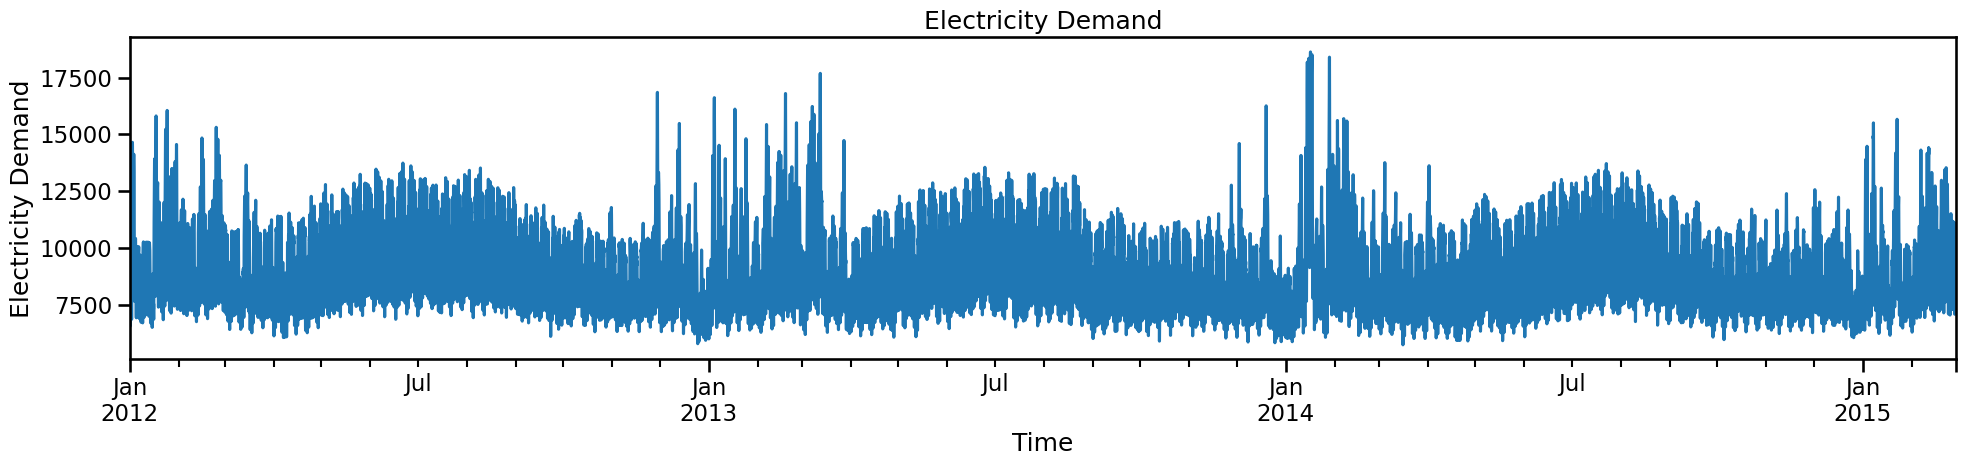

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

data.loc['2012':].plot(y='demand', legend=None, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Demand')
ax.set_title('Electricity Demand')
plt.tight_layout()

In [5]:
data.shape

(115368, 1)

## Using sklearn to create dummy features

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config

set_config(transform_output='pandas')

In [7]:
df = data.copy()

In [8]:
df['month_of_year'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week

In [9]:
# create one hot encoder transformer
transformer = OneHotEncoder(sparse_output=False,
                            drop='first')

In [10]:
# create seasonal dummy variables from date features
result = transformer.fit_transform(df[['month_of_year', 'week_of_year']])

result.head()

,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,...,week_of_year_44.0,week_of_year_45.0,week_of_year_46.0,week_of_year_47.0,week_of_year_48.0,week_of_year_49.0,week_of_year_50.0,week_of_year_51.0,week_of_year_52.0,week_of_year_53.0
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating seasonal dummies using sklearn and sktime
Let's combine the `DateTimeFeatures` transformer from sktime with `OneHotEncoder` inside of a pipeline to make it easier to create seasonal dummy features.

In [11]:
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.pipeline import make_pipeline 

In [12]:
# specify which datetime features to create
# and then convert into dummy/one hot features
seasonal_dummies = ['week_of_year',
                    'month_of_year']

# create datetime feature transformer
datetime_transformer = DateTimeFeatures(
    manual_selection=seasonal_dummies,
    keep_original_columns=False,
)

# one hot encoder
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    drop='first'
)

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


In [13]:
# combine the 2 transformers in a pipeline
seasonal_dummies_feats = make_pipeline(datetime_transformer, one_hot_encoder)

seasonal_dummies_feats

Pipeline(steps=[('datetimefeatures',
                 DateTimeFeatures(manual_selection=['week_of_year', 'month_of_year'])),
                ('onehotencoder',
                 OneHotEncoder(drop='first', sparse_output=False))])

In [14]:
# fit and transform to create our features
result = seasonal_dummies_feats.fit_transform(data)
result.head()

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Let's build some forecasts

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import clone

from sklearn import set_config
set_config(transform_output='pandas')

In [16]:
df = data.copy()

In [17]:
target = ['demand']

In [18]:
# prepare transformers
# polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(),
    PolynomialFeatures(degree=1, include_bias=False)
)

# datetime features
datetime_features = [
    'month_of_year',
    'day_of_week',
    'hour_of_day'
]

datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features,
    keep_original_columns=False
)

one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    drop='first'
)

seasonal_dummies_feats = make_pipeline(datetime_feats, one_hot_encoder)

# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1]  # Lag features.
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


In [19]:
# create a pipeline 
pipeline = make_union(seasonal_dummies_feats,
                      time_feats,
                      lag_window_feats)

# apply min max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [20]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('datetimefeatures',
                                                                  DateTimeFeatures(manual_selection=['month_of_year', 'day_of_week',
                                   'hour_of_day'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse_output=False))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1]}, target_cols=['demand'],
                 truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [21]:
pipeline.fit_transform(df).head()

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,...,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,time_since_2002-01-01 00:00:00,demand_lag_1
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.112939
2002-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.112939
2002-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000017,0.131101
2002-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000026,0.075171
2002-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000035,0.031645


In [22]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


Let's build a recursive forecast

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [24]:
# CONFIG
forecast_start_time = df.index.max() - pd.DateOffset(weeks=2)

# define number of steps to forecast
num_of_forecast_steps = 24*14

# define the model
model = LinearRegression()

# create a list of periods that we will forecast over
forecast_horizon = pd.date_range(
    start=forecast_start_time,
    periods=num_of_forecast_steps,
    freq='H'
)

# how much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_24716\3329548654.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_horizon = pd.date_range(


In [25]:
# CREATE TRAINING AND TESTING DATAFRAME
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

In [26]:
# FEATURE ENGINEERING
# create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which havve certain characters
# we replace these with _
if 'lightgbm' in model.__module__:
    X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


In [27]:
# MODEL TRAINING
# train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

In [28]:
# CREATE DYNAMIC PREDICTION DATAFRAME
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# create `df_predict` which has data going as far back as needed
# to create features which need past values
df_predict = df_train.loc[look_back_start_time:].copy()

# extend index into forecast horizon
df_predict = pd.concat(
    [df_predict, pd.DataFrame(index=forecast_horizon)]
)

In [29]:
# RECURSIVE FORECASTING LOOP
for forecast_time in forecast_horizon:
    # compute features during forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]

    # predict one step ahead
    y_pred = model.predict(X_test)

    # append forecast to the target variable column in `df_predict`
    # this `df_predict` is ready for the next iteration where we will 
    # recompute features derived from the target such as lags and windows
    df_predict.loc[[forecast_time], target] = y_pred

In [30]:
# GET FORECAST AND TEST VALUES
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [31]:
# CREATE IN-SAMPLE PREDICTIONS
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Text(0.5, 1.0, 'Recursive forecast with LinearRegression()')

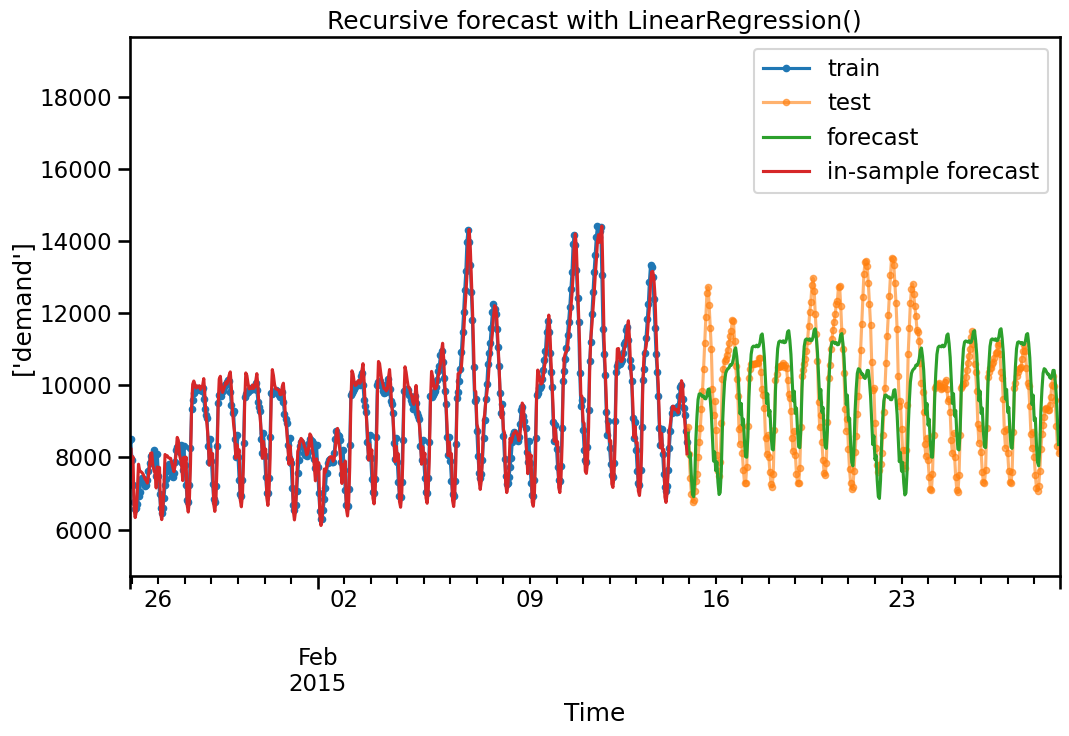

In [32]:
# PLOTTING
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=3))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Recursive forecast with {model}")

In [33]:
# compute RMSE
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_true=y_test.loc[y_forecast.index],
                        y_pred=y_forecast)

1210.1431135492383